# Tuorial 5, Question 2

In [1]:
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

In [2]:
no_labels = 1
no_features = 2
no_exps = 10

lr = 0.05
no_epochs = 5000
batch_size = 70
patience = 10
no_folds = 5

hidden_units = [2, 4, 6, 8, 10]

In [3]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden),
            nn.Sigmoid(),
            nn.Linear(no_hidden, no_labels),
        )

    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits

In [5]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [6]:
# perform experiments
def train_exp(X, Y):
    
    err = []
    for fold in range(no_folds):
        start, end = fold*20, (fold+1)*20
        x_test, y_test = X[start:end], Y[start:end]
        x_train  = np.append(X[:start], X[end:], axis=0)
        y_train = np.append(Y[:start], Y[end:], axis=0) 

        err_ = []
        for no_hidden in hidden_units:

            model = MLP(no_features, no_hidden, no_labels)
    
            loss_fn = torch.nn.MSELoss()
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)
            early_stopper = EarlyStopper(patience=patience, min_delta=0)
        
            for epoch in range(no_epochs):
                pred = model(torch.tensor(x_train, dtype=torch.float))
                train_loss = loss_fn(pred, torch.tensor(y_train, dtype=torch.float))
    
                # Backpropagation
                optimizer.zero_grad()
                train_loss.backward()
                optimizer.step()
        
                pred = model(torch.tensor(x_test, dtype=torch.float))
                test_loss = loss_fn(pred, torch.tensor(y_test, dtype=torch.float))
            
                if early_stopper.early_stop(test_loss): 
                    break
                    
            err_.append(test_loss.item())
                
        err.append(err_)

    cv_err = np.mean(np.array(err), axis = 0)

    return cv_err

In [7]:
# generate training data
X = np.zeros((10*10, 2))
no_data = 0
for i in np.arange(-1.0, 1.001, 2.0/9.0):
    for j in np.arange(-1.0, 1.001, 2.0/9.0):
        X[no_data] = [i, j]
        no_data += 1
Y = np.zeros((no_data, 1))
Y[:,0] = np.sin(np.pi*X[:,0])*np.cos(2*np.pi*X[:,1])

In [8]:
idx = np.arange(no_data)

# perform experiments
err = []
print('hidden units: {}'.format(hidden_units))
for exp in range(no_exps):
 
    np.random.shuffle(idx)
    err.append(train_exp(X[idx], Y[idx]))
    print('exp: {}, errors: {}'.format(exp, np.array(err[exp])))

hidden units: [2, 4, 6, 8, 10]
exp: 0, errors: [0.25438894 0.24965696 0.26125952 0.25600457 0.25328684]
exp: 1, errors: [0.25141658 0.24929    0.24865358 0.25548323 0.262043  ]
exp: 2, errors: [0.24677186 0.24782917 0.25550789 0.25769759 0.25525048]
exp: 3, errors: [0.24588992 0.24667284 0.25094872 0.25302261 0.24871422]
exp: 4, errors: [0.2467606  0.24877921 0.25066612 0.25010398 0.25943485]
exp: 5, errors: [0.2521703  0.25417797 0.25531974 0.25271434 0.25669273]
exp: 6, errors: [0.25478806 0.24708671 0.25319684 0.24255435 0.24506873]
exp: 7, errors: [0.25110444 0.25212851 0.25346287 0.25382894 0.25035039]
exp: 8, errors: [0.24659746 0.2513017  0.2548514  0.2547345  0.2505784 ]
exp: 9, errors: [0.24926125 0.24663129 0.25126392 0.25526856 0.24949346]


In [9]:
# print the mean errors of different models
mean_err = np.mean(np.array(err), axis = 0)
print('mean errors: {}'.format(mean_err))
print(' *hidden units* %d '%hidden_units[np.argmin(mean_err)])

mean errors: [0.24991494 0.24935543 0.25351306 0.25314127 0.25309131]
 *hidden units* 4 


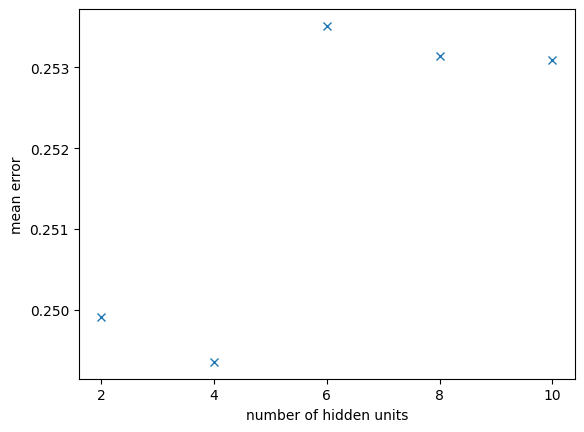

In [10]:
plt.figure(1)
plt.plot(hidden_units, mean_err, marker = 'x', linestyle = 'None')
plt.xticks(hidden_units)
plt.xlabel('number of hidden units')
plt.ylabel('mean error')
plt.show()